In [ ]:
# Notes

# Images save to a weird folder, need to recorrect

In [45]:
# Importing all necessary modules

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
import io

In [46]:
# Welcome to the Lahmas Lab Lascar Data Processor!
# Please answer the questions below and run your code directly in a jupyter notebook.

# Where is the folder you would like to process?
folder_path = r'Merger_Data/Merged_Data' # You can 'copy file path' of the folder in your file manager.

# What are the labels for each variable in the .csv files?
time_name = 'Datetime' # Label of time variable
temp_name = 'Temperature (�C)' # Label of temperature variable
rh_name = 'RH (%)' # Label of relative humidity variable
td_name = 'Dew Point (�C)' # Label of dew point temperature variable

# What will the name be of your new file-holding folder?
file_folder_name = 'Output_Data' # Don't use spaces or special characters.

# What will the name be of your new image-holding folder?
image_folder_name = 'Images'

In [47]:
# Creating the new folder where all the processed files will end up.

if os.path.exists(file_folder_name):
    print('\nThis folder already exists!\n\nIf you wish to continue with this folder anyway, \
run the next block.\nOtherwise, rewrite the folder path/name in block 1.\n')

else:
    os.makedirs(file_folder_name)
    print('\nYour new folder path is:\n"', file_folder_name, '"\n\nRun next block\n')


This folder already exists!

If you wish to continue with this folder anyway, run the next block.
Otherwise, rewrite the folder path/name in block 1.



In [48]:
# Creating the new folder where all the images will end up.

if os.path.exists(image_folder_name):
    print('\nThis folder already exists!\n\nIf you wish to continue with this folder anyway, \
run the next block.\nOtherwise, rewrite the folder path/name in block 1.\n')

else:
    os.makedirs(image_folder_name)
    print('\nYour new folder path is:\n"', image_folder_name, '"\n\nRun next block\n')


Your new folder path is:
" Images "

Run next block



In [49]:
# File initialization function

def file_initialize(file_path, time_name, rh_name, td_name):

    ### INITIALIZATION
    
    # Prints selected file name
    print("Initializing file:", os.path.basename(file_path), '\n')

    # Converting .csv in ANSI encoding to UTF-8 encoding
    #df = pd.read_csv(file_path, encoding='ANSI')
    # df.to_csv(file_path, encoding='utf-8', index=False)
        
    # Creates dataframe from .csv
    dataframe = pd.read_csv(file_path)
    
    # Skips first values as they may have been taken & tainted during installation
    dataframe = dataframe.iloc[5:].reset_index(drop=True)
    
    # Changes time string to datetime type
    dataframe['Time_fixed'] = pd.to_datetime(dataframe[time_name])
    
    # Define the labels of the corrected variables
    rh_cor_name = 'RH Corrected (%)'
    td_cor_name = 'Dew Point Corrected (°C)'
    
    
    ## RH and Td correction
    
    # Creating lists to insert corrected RH and Td values
    RH_cor = [None] * len(dataframe)
    Td_cor = [None] * len(dataframe)
    
    # Iterating through rows to update RH values out of 0-100% range and Td values.
    for i in range(0,len(dataframe)):
        if dataframe.loc[i, rh_name] > 100:
            RH_cor[i] = 100 # RH is adjusted to 100% as it must be saturated
            Td_cor[i] = dataframe.loc[i, temp_name] # Td is equal to T
        
        else: # Everything stays the same
            RH_cor[i] = dataframe.loc[i, rh_name]
            Td_cor[i] = dataframe.loc[i, td_name]
            
    # Creating columns for the lists to merge into the dataframe
    dataframe[rh_cor_name] = RH_cor
    dataframe[td_cor_name] = Td_cor
    
    
    ## Initializing daily and monthly temperature averages for plotting
    
    # Create index using the time column
    dataframe = dataframe.sort_values('Time_fixed')
    dataframe = dataframe.set_index('Time_fixed', drop=False)
    
    # Resample by day and calculate daily min, max, avg for temperature
    daily_summary_T = dataframe[temp_name].resample('1D')\
        .agg(['mean', 'min', 'max']).dropna().reset_index()
    daily_summary_T.columns = ['Date', 'T_avg', 'T_min', 'T_max']
    
    daily_summary_T['DateTime'] = pd.to_datetime(daily_summary_T['Date'])
    daily_summary_T = daily_summary_T.set_index('Date')
    monthly_summary_T = daily_summary_T.resample('ME')\
        .agg({'T_avg': 'mean','T_min': 'min','T_max': 'max'})\
            .dropna().reset_index()
            
            
    ## Initializing daily and monthly relative humidity averages for plotting
            
    # Resample by day and calculate daily min, max, avg for RH
    daily_summary_rh = dataframe[rh_cor_name].resample('1D')\
        .agg(['mean', 'min', 'max']).dropna().reset_index()
    daily_summary_rh.columns = ['DateTime', 'RH_avg', 'RH_min', 'RH_max']
    
    # Resample by day and calculate daily min, max, avg for RH
    daily_summary_rh = dataframe[rh_cor_name].resample('1D')\
        .agg(['mean', 'min', 'max']).dropna().reset_index()
    daily_summary_rh.columns = ['DateTime', 'RH_avg', 'RH_min', 'RH_max']
    
    daily_summary_rh['DateTime'] = pd.to_datetime(daily_summary_rh['DateTime'])
    daily_summary_rh = daily_summary_rh.set_index('DateTime', drop=False)
    monthly_summary_rh = daily_summary_rh.resample('ME')\
        .agg({'RH_avg': 'mean','RH_min': 'min','RH_max': 'max'})\
            .dropna().reset_index()

    return dataframe, monthly_summary_T, monthly_summary_rh

In [50]:
# Function writing a new .csv in your new folder

def write_csv(basename, dataframe):

    # Creating new file path and name
    new_file_path = new_path + '//PROCESSED_' + os.path.basename(basename)
    
    # Prints selected file name
    print('Writing new file:', os.path.basename(new_file_path), '\n')

    # Renaming labels to standard
    dataframe.rename(columns={time_name: 'Datetime (MM/DD/YYYY HR:MN)', 
                              temp_name: 'Temperature (°C)',
                              rh_name: 'RH (%)',
                              td_name: 'Dew Point (°C)'}, inplace=True)
    
    # Removing custom index
    dataframe.reset_index(drop=True, inplace=True)
    
    # Removing unnecessary columns
    del dataframe['Time_fixed']
    
    # Writing the new dataframe to your computer
    dataframe.to_csv(new_file_path, index=False, encoding='utf-8-sig')

In [57]:
# Function generating and exporting relevant plots

# Monthly Temperature Plot
def plot_monthly_temp(monthly_summary_T, filename):

    print('Plotting monthly temperature:\n')
    
    # Calculate time differences between consecutive months
    date_diffs = monthly_summary_T['Date'].diff()

    # Identify gaps larger than 1 month
    gaps = monthly_summary_T[date_diffs > pd.Timedelta(days=31)]

    plt.figure(figsize=(12, 6))

    # Plot monthly average, min, and max
    plt.plot(
        monthly_summary_T['Date'], 
        monthly_summary_T['T_avg'], 
        label='Average Temp', 
        color='black', 
        linewidth=2.5
    )
    plt.plot(
        monthly_summary_T['Date'], 
        monthly_summary_T['T_min'], 
        label='Min Temp', 
        color='blue', 
        linestyle='dashdot', 
        linewidth=0.5
    )
    plt.plot(
        monthly_summary_T['Date'], 
        monthly_summary_T['T_max'], 
        label='Max Temp', 
        color='red', 
        linestyle='dashdot', 
        linewidth=0.5
    )

    plt.title('Monthly Temperature Summary:')
    plt.xlabel('Date')
    plt.ylabel('Temperature')

    ax = plt.gca()

    # Custom tick dates
    custom_tick_dates = [
        datetime(2006, 1, 1), datetime(2007, 1, 1), datetime(2008, 1, 1),
        datetime(2009, 1, 1), datetime(2010, 1, 1), datetime(2011, 1, 1),
        datetime(2012, 1, 1), datetime(2013, 1, 1), datetime(2014, 1, 1),
        datetime(2015, 1, 1), datetime(2016, 1, 1), datetime(2017, 1, 1),
        datetime(2018, 1, 1), datetime(2019, 1, 1), datetime(2020, 1, 1),
        datetime(2021, 1, 1), datetime(2022, 1, 1), datetime(2023, 1, 1),
        datetime(2024, 1, 1),
    ]
    
    ax.set_xticks(custom_tick_dates)
    
    # Format tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.gcf().autofmt_xdate()

    # Shade missing data regions
    for i, row in gaps.iterrows():
        gap_start = monthly_summary_T.loc[i - 1, 'Date']
        gap_end = row['Date']
        ax.axvspan(gap_start, gap_end, color='gray', alpha=0.3)

    plt.legend()
    plt.show()

    filename = filename.replace('csv', 'png')
    
    plt.savefig(filename)

# Monthly Relative Humidity Plot
def plot_monthly_rh(monthly_summary_rh, filename):

    print('Plotting monthly relative humidity:\n')
    
    # Calculate time differences between consecutive months
    date_diffs = monthly_summary_rh['DateTime'].diff()

    # Identify gaps larger than 1 month
    gaps = monthly_summary_rh[date_diffs > pd.Timedelta(days=31)]

    plt.figure(figsize=(12, 6))

    # Plot monthly average, min, and max RH
    plt.plot(
        monthly_summary_rh['DateTime'], 
        monthly_summary_rh['RH_avg'], 
        label='Average RH', 
        color='black', 
        linewidth=2.5
    )
    plt.plot(
        monthly_summary_rh['DateTime'], 
        monthly_summary_rh['RH_min'], 
        label='Min RH', 
        color='blue', 
        linestyle='dashdot', 
        linewidth=0.5
    )
    plt.plot(
        monthly_summary_rh['DateTime'], 
        monthly_summary_rh['RH_max'], 
        label='Max RH', 
        color='red', 
        linestyle='dashdot', 
        linewidth=0.5
    )

    plt.title('Monthly Relative Humidity Summary:')
    plt.xlabel('DateTime')
    plt.ylabel('Relative Humidity')

    ax = plt.gca()

    # Custom tick dates (same as before)
    custom_tick_dates = [
        datetime(2006, 1, 1), datetime(2007, 1, 1), datetime(2008, 1, 1),
        datetime(2009, 1, 1), datetime(2010, 1, 1), datetime(2011, 1, 1),
        datetime(2012, 1, 1), datetime(2013, 1, 1), datetime(2014, 1, 1),
        datetime(2015, 1, 1), datetime(2016, 1, 1), datetime(2017, 1, 1),
        datetime(2018, 1, 1), datetime(2019, 1, 1), datetime(2020, 1, 1),
        datetime(2021, 1, 1), datetime(2022, 1, 1), datetime(2023, 1, 1),
        datetime(2024, 1, 1),
    ]
    ax.set_xticks(custom_tick_dates)
    
    # Format tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.gcf().autofmt_xdate()

    # Shade missing data regions
    for i, row in gaps.iterrows():
        gap_start = monthly_summary_rh.loc[i - 1, 'DateTime']
        gap_end = row['DateTime']
        ax.axvspan(gap_start, gap_end, color='gray', alpha=0.3)

    plt.legend()
    plt.show()

    filename = filename.replace('csv', 'png')
    
    plt.savefig(filename)

1 .

Initializing file: LlanUp-1_17Jul06_5Jul19_3955m.csv 

Initialization complete

Plotting monthly temperature:



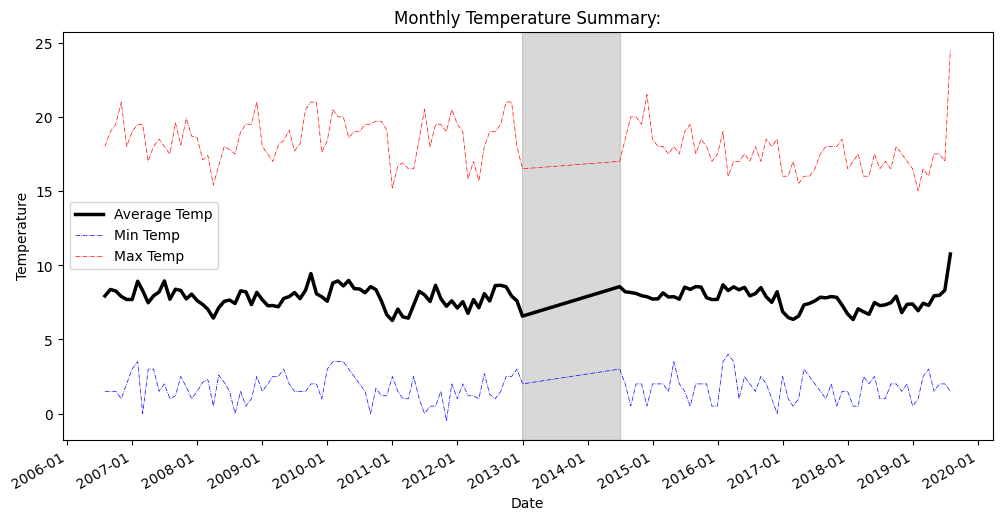

An error occured. File skipped.

2 .

Initializing file: LlanUp-1_17Jul06_5Jul19_3955m.png 

An error occured. File skipped.

3 .

Initializing file: LlanUp-2_17Jul06_5Jul19_4122m.csv 

Initialization complete

Plotting monthly temperature:



<Figure size 640x480 with 0 Axes>

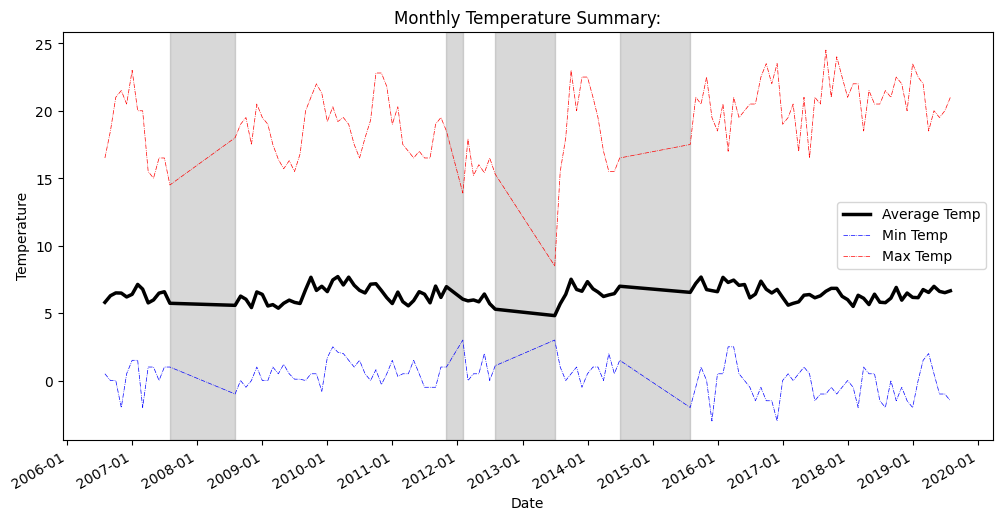

An error occured. File skipped.

4 .

Initializing file: LlanUp-2_17Jul06_5Jul19_4122m.png 

An error occured. File skipped.

5 .

Initializing file: LlanUp-3_17Jul06_5Jul19_4355m.csv 

Initialization complete

Plotting monthly temperature:



<Figure size 640x480 with 0 Axes>

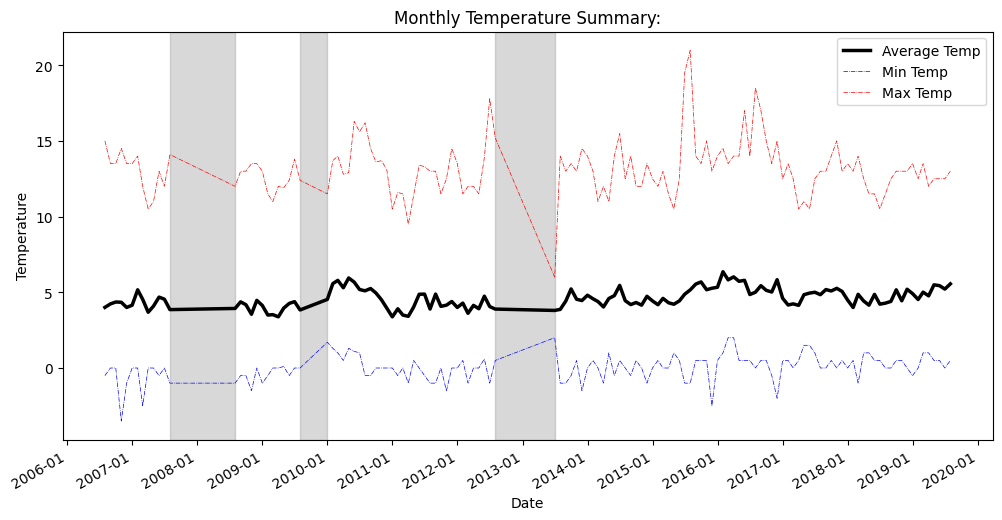

An error occured. File skipped.

6 .

Initializing file: LlanUp-3_17Jul06_5Jul19_4355m.png 

An error occured. File skipped.

---------------------------

FOLDER TRAVERSED

Files processed:
 [] 

Files skipped due to error:
 ['LlanUp-1_17Jul06_5Jul19_3955m.csv', 'LlanUp-1_17Jul06_5Jul19_3955m.png', 'LlanUp-2_17Jul06_5Jul19_4122m.csv', 'LlanUp-2_17Jul06_5Jul19_4122m.png', 'LlanUp-3_17Jul06_5Jul19_4355m.csv', 'LlanUp-3_17Jul06_5Jul19_4355m.png']


<Figure size 640x480 with 0 Axes>

In [56]:
# Walks through the folder and goes through each file one at a time.

directory = folder_path
counter = 0
completed = []
skipped = []

# Iterate over files in directory
for path, folders, files in os.walk(directory):
    
    for filename in files:
        
        try:
            counter = counter + 1
            print(counter, '.\n')
            filename = directory + '//' + filename
            
            data, monthly_summary_T, monthly_summary_rh = file_initialize(filename, time_name, rh_name, td_name)
            print('Initialization complete\n')

            plot_monthly_temp(monthly_summary_T, filename)
            plot_monthly_rh(monthly_summary_rh, filename)
            print('Plotting complete\n')
            
            write_csv(os.path.basename(filename), data)
            print('Writing complete\n')
            
            completed.append(os.path.basename(filename))

        except:
            print('An error occured. File skipped.\n')
            skipped.append(os.path.basename(filename))

print('---------------------------\n\nFOLDER TRAVERSED\n')
print('Files processed:\n', completed, '\n')
print('Files skipped due to error:\n', skipped)